## Training a Random Forests Model

In [2]:
import os

from qsprpred.models import SklearnModel
from qsprpred.data import QSPRDataset
from qsprpred.models import OptunaOptimization
from qsprpred.models import CrossValAssessor
from sklearn.ensemble import RandomForestClassifier
from qsprpred.data import RandomSplit, BootstrapSplit
from qsprpred.data.descriptors.fingerprints import MorganFP


os.makedirs("../output/models", exist_ok=True)

# Read receptor name from the text file
with open("../output/data/receptor.txt", "r") as file:
    receptor = file.read().strip()

dataset = QSPRDataset.fromTableFile(
    filename=f"../output/data/OATP1b1_Dataset.tsv",
    store_dir="../output/data",
    name=f"Splitting_OATP1b1.tsv",
    target_props=[{"name": "pchembl_value_Mean", "task": "SINGLECLASS", "th": [6.5]}],
    random_state=42
)

dataset.addDescriptors([MorganFP(radius=3, nBits=2048)])
dataset.getDescriptors().shape

def print_split(ds):
    train, test = ds.getFeatures()
    print(train.shape)
    print(test.shape)
    print(test.index)


print_split(dataset)

(14, 2048)
(0, 2048)
Index([], dtype='object', name='QSPRID')


In [7]:
from qsprpred.data.chem.clustering import ScaffoldClusters
from qsprpred.data.chem.scaffolds import BemisMurckoRDKit
from qsprpred.data import ClusterSplit

#Create the ScaffoldClusters object (this defines the clustering strategy)
molecule_clusters = ScaffoldClusters(
    scaffold=BemisMurckoRDKit()  # Use the default scaffold generator
)

#Create the ClusterSplit object, passing the molecule_clusters strategy
cluster_split = ClusterSplit(
    dataset=dataset,        # Your QSPRDataset
    test_fraction=0.2,      # 20% test split
    clustering=molecule_clusters,
    seed=42
)

#Run the split. This will trigger clustering internally.
dataset.split(cluster_split)

#Confirm split success
def print_split(ds):
    train, test = ds.getFeatures()
    print(train.shape)
    print(test.shape)


print_split(dataset)


(7624, 2048)
(4085, 2048)


In [10]:
model = SklearnModel( #test with new model types
    base_dir="../output/models/",
    alg=RandomForestClassifier,
    name="Splitting_hERG_100trials",
    random_state=dataset.randomState
)
search_space_bs = {
    "n_estimators": ["int", 10, 2000],
    "max_depth": ["int", 3, 25],
    "min_samples_split": ["int", 2, 20],
    "min_samples_leaf": ["int", 1, 20],
    "max_features": ["uniform", 0.1, 1.0],
    "class_weight": ["categorical", ["balanced", "balanced_subsample", None]]
}

optimizer = OptunaOptimization(
    param_grid=search_space_bs,
    n_trials=1,  
    model_assessor=CrossValAssessor(
        scoring="roc_auc",
        split=BootstrapSplit(split=RandomSplit(0.2), n_bootstraps=5)
    )
)
optimizer.optimize(model, dataset)

[I 2025-03-19 17:08:24,514] A new study created in memory with name: no-name-bdcd1191-ab61-41e2-8bbc-55517682c33b
[W 2025-03-19 17:08:26,080] Trial 0 failed with parameters: {'n_estimators': 755, 'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 0.24041677639819287, 'class_weight': None} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/s2787504/.conda/envs/qsprpred/lib/python3.13/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/home/s2787504/QSPRpred/qsprpred/models/hyperparam_optimization.py", line 247, in <lambda>
    lambda t: self.objective(t, model, ds), self.nTrials, n_jobs=self.nJobs
              ~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/home/s2787504/QSPRpred/qsprpred/models/hyperparam_optimization.py", line 301, in objective
    scores = self.runAssessment(
        model,
    ...<4 lines>...
        **kwargs,
    )
  File "/home/s2787504

KeyboardInterrupt: 

In [ ]:
dataset.getDescriptors().shape

def print_split(ds):
    train, test = ds.getFeatures()
    print(train.shape)
    print(test.shape)


print_split(dataset)

(7624, 2048)
(4085, 2048)


### Bootstrapping with optimized model

In [ ]:
# run bootstrapping ten times with the optimized model
CrossValAssessor(
    scoring="roc_auc",
    split=BootstrapSplit(split=RandomSplit(0.2), n_bootstraps=10)
)(model, dataset)

array([0.71789729, 0.72839902, 0.73951219, 0.73966008, 0.72824873,
       0.71105363, 0.72507853, 0.70507801, 0.71504803, 0.70774791])

In [ ]:
# evaluate on the test set as well
from qsprpred.models import TestSetAssessor

TestSetAssessor(scoring="roc_auc")(model, dataset)

array([0.65676313])

In [ ]:
_ = model.save()

In [ ]:
# plot the results for bootstrapping
from qsprpred.plotting.classification import ROCPlot

plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="cv")

NameError: name 'plot' is not defined

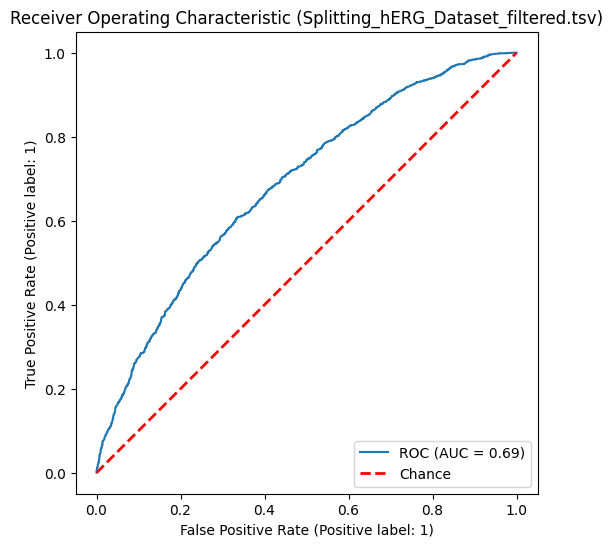

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot test set results
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="ind")

## Cross validation using ScaffoldSplit

In [ ]:
from qsprpred.data import ScaffoldSplit
from qsprpred.models import SklearnModel
from qsprpred.models import CrossValAssessor
from qsprpred.data.descriptors import BemisMurckoRDKit

CrossValAssessor(
    scoring="roc_auc",
    split=ScaffoldSplit(n_folds=10, scaffold=BemisMurckoRDKit())
)(model, dataset)

ImportError: cannot import name 'BemisMurckoRDKit' from 'qsprpred.data.descriptors' (/home/s2787504/QSPRpred/qsprpred/data/descriptors/__init__.py)

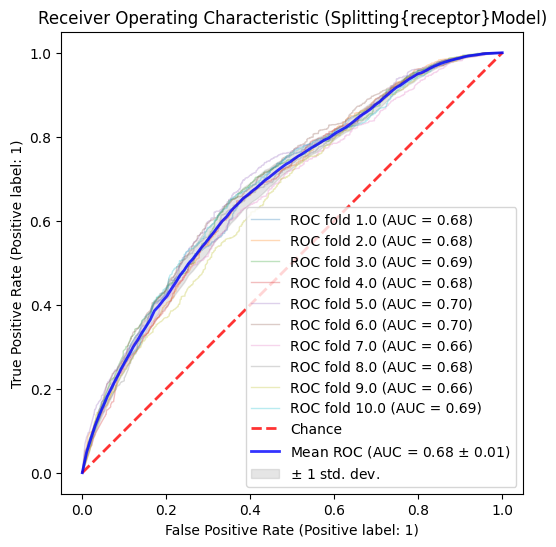

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [ ]:
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="cv")

## Cross validation using Temporal split

<Axes: >

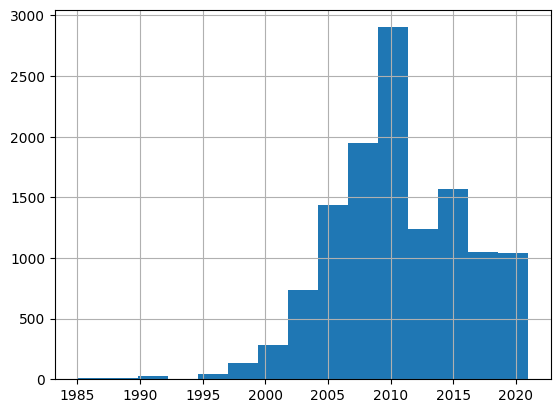

In [ ]:
dataset.getProperty("Year").hist(bins=15)

In [ ]:
from qsprpred.data import TemporalSplit

CrossValAssessor(
    scoring="roc_auc",
    split=TemporalSplit(timesplit=[2000, 2010, 2020], timeprop="Year")
)(model, dataset)

array([0.54670196, 0.56349362, 0.58742416])

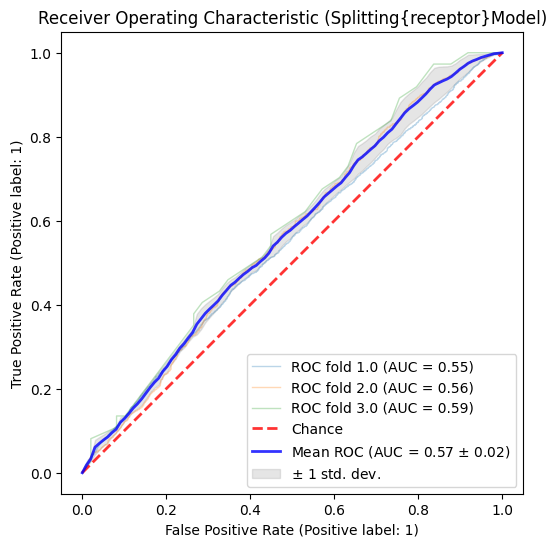

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [ ]:
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="cv")

These splits are not saved to the dataset, but the assessments and optimizations can be reproduced by setting the random state to the same value. You can also explicitly save the splits to by adding a monitor to the `ModelAssessor` or `HyperparameterOptimizer`, see the [monitoring tutorial](../../advanced/modelling/monitoring.ipynb) for more information.

### Making predictions

In [ ]:
smiles_list = ["c1(cc(c(O)cc1)O)CCN", "CC(=O)OC1=CC=CC=C1C(=O)O",
               "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"]

model.predictMols(smiles_list)

NotFittedError: This ExtraTreesClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Reloading

In [ ]:
dataset = QSPRDataset.fromFile(
    "./output/data/{receptor}_Dataset/{receptor}Dataset_meta.json")
model = SklearnModel.fromFile(
    "./output/models/{receptor}_Model/QuickStartModel_meta.json")
# or
dataset = QSPRDataset(
    name="{receptor}_Dataset",
    store_dir="./data/",
)
model = SklearnModel(
    name="{receptor}Model",
    base_dir="./output/models/"
)